In [3]:
import pandas as pd 
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sbn
from urllib.parse import urlencode
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [4]:
agency_dictionary={'CS': 'Administration for Children\'s Services',
'BIC' : 'Business Integrity Commission',
'BNYDC': 'Brooklyn Navy Yard Development Corp',
'BOC': 'Board of Correction',
'BPL': 'Brooklyn Public Library',
'BSA': 'Board of Standards and Appeals',
'BXDA': 'Bronx District Attorney',
'CCRB': 'Civilian Complaint Review Board',
'CFB': 'Campaign Finance Board',
'COIB': 'Conflicts of Interest Board',
'CPC': 'City Planning Commission',
'CUNY': 'City University of New York',
'DANY': 'New York County District Attorney',
'DCA': 'Department of Consumer Affairs',
'DCAS': 'Department of Citywide Administrative Services',
'DCLA': 'Department of Cultural Affairs',
'DCP': 'Department of City Planning',
'DDC': 'Department of Design and Construction',
'DEP': 'Department of Environmental Protection',
'DFTA': 'Department for the Aging',
'DHS': 'Department of Homeless Services',
'DOB': 'Department of Buildings',
'DOC': 'Department of Correction',
'DOF': 'Department of Finance',
'DOHMH': 'Department of Health and Mental Hygiene',
'DOI': 'Department of Investigation',
'DoITT': 'Department of Information Technology and Telecommunications',
'DOP': 'Department of Probation',
'DORIS': 'Department of Records and Information Services',
'DOT': 'Department of Transportation',
'DPR': 'Department of Parks and Recreation',
'DSNY': 'Department of Sanitation',
'DYCD': 'Department of Youth and Community Development',
'ECB': 'Environmental Control Board',
'EDC': 'Economic Development Corporation',
'EEPC': 'Equal Employment Practices Commission',
'FCRC': 'Franchise and Concession Review Committee',
'FDNY': 'Fire Department of New York',
'FISA': 'Financial Information Services Agency',
'HHC': 'Heal and Hospitals Corporation',
'HPD': 'Department of Housing Preservation and Development',
'HRA': 'Human Resources Administration',
'IBO': 'Independent Budget Office',
'KCDA': 'Kings County District Attorney',
'LPC': 'Landmarks Preservation Commission',
'MOCJ': 'Mayor’s Office of Criminal Justice',
'MOCS': 'Mayor\'s Office of Contract Services',
'NYCDOE': 'Department of Education',
'NYCEM': 'Emergency Management',
'NYCERS': 'New York City Employees Retirement System',
'NYCHA': 'New York City Housing Authority',
'NYCLD': 'Law Department',
'NYCTAT': 'New York City Tax Appeals Tribunal',
'NYPD': 'New York City Police Department',
'NYPL': 'New York Public Library',
'OATH': 'Office of Administrative Trials and Hearings',
'OCME': 'Office of Chief Medical Examiner',
'OMB': 'Office of Management & Budget',
'OSNP': 'Office of the Special Narcotics Prosecutor',
'PPB': 'Procurement Policy Board',
'QCDA': 'Queens District Attorney',
'QPL': 'Queens Borough Public Library',
'RCDA': 'Richmond County District Attorney',
'RGB': 'Rent Guidelines Board',
'SBS': 'Small Business Services',
'SCA': 'School Construction Authority',
'TBTA': 'Triborough Bridge and Tunnel Authority',
'TLC': ' Taxi and Limousine Commission',
'TRS': 'Teachers\' Retirement System'
}




In [3]:
point_table  = 'new_york_311'
block_groups = 'ny_block_groups' 

In [4]:
def table_columns(table_name, include_geom=False):
    query = '''
        select * from {table_name} limit 1 
    '''.format(table_name='new_york_311')
    params = {'q': query, 'format':'csv' }

    result =  (pd.read_csv('https://stuartlynn.carto.com/api/v2/sql?'+ urlencode(params)))

    if not include_geom:
        result = result.drop(['the_geom','the_geom_webmercator'],axis=1)
    return result.columns
                

In [5]:
columns = table_columns(point_table)

In [6]:
def load_point_data(table_name,columns=['*'], limit=None):
    if limit:
        limit_str = 'limit {limit}'.format(limit=limit)
    else:
        limit_str = ''
        
    query = '''
            select {columns} from {table_name} {limit_str}
            '''.format(table_name=table_name, 
                       columns= ','.join(columns),
                       limit_str = limit_str)

    params = {'q': query, 'format':'csv' }

    result =  (pd.read_csv('https://stuartlynn.carto.com/api/v2/sql?'+ urlencode(params))).set_index('cartodb_id')
    return result

In [19]:
def get_complaint_types(table_name, complaint_col='complaint_type'):
    query = '''
        select {complaint_col}, count(*) as no from {table_name} 
        group by {complaint_col}
        ORDER BY 1 ASC
    '''.format(table_name=table_name, complaint_col=complaint_col)
    params = {'q': query, 'format':'csv' }


    result =  (pd.read_csv('https://stuartlynn.carto.com/api/v2/sql?'+ urlencode(params)))
    return result

In [14]:
def aggregation_query(categories):
    return """
    create table ny_311_aggregated as (
    SELECT geom_refs,complaint_type, count(*) as no
        FROM stuartlynn.ny_block_groups, new_york_311
        where ST_WITHIN(new_york_311.the_geom, ny_block_groups.the_geom) AND
        complaint_type in ({categories})
        group by geom_refs,complaint_type
        )
    """.format(categories=categories)

In [122]:
def get_aggregated_data(point_table, geom_table, categories, category_col, geom_id):
    query='''
        with agg as (
        SELECT {geom_id},agency, count(*) as no
        FROM  {point_table}
        where {geom_id} is not null
        group by {category_col},{geom_id}
        )
        select agg.*, total_pop, pc_white, median_income from agg,
        stuartlynn.{geom_table} 
        where {geom_table}.name = agg.{geom_id}
    '''.format(point_table=point_table, 
               geom_table=geom_table,
               category_col=category_col,
               geom_id = geom_id
               )
              
    params = {'q': query, 'format':'csv' }
    
    result =  (pd.read_csv('https://stuartlynn.carto.com/api/v2/sql?'+ urlencode(params)))
    result['normalized'] = (result['no']/result['total_pop']).fillna(0)
    pivot = result.pivot_table(index=geom_id, columns=category_col,values='no').fillna(0)
    return pivot

In [123]:
agg_tract_not_normalized = get_aggregated_data('new_york_311', 'ny_census_tracts', None, 'agency', 'tract_id')

In [128]:
agg_tract_not_normalized.columns = [ c if c not in agency_dictionary else agency_dictionary[c]  for c in agg_tract_not_normalized.columns]


In [130]:
agg_tract_not_normalized.to_csv('tract_agencies_not_normalized.csv')

In [127]:
get_aggregated_data

<function __main__.get_aggregated_data>

In [27]:
agg_tract = get_aggregated_data('new_york_311', 'ny_census_tracts', None, 'agency', 'tract_id')
agg_tract.columns = [ c if c not in agency_dictionary else agency_dictionary[c]  for c in agg_tract.columns]
agg_tract=agg_tract.replace([np.inf, -np.inf], np.nan)
agg_tract_top = agg_tract[top_complaints.index]



        with agg as (
        SELECT tract_id,agency, count(*) as no
        FROM  new_york_311
        where tract_id is not null
        group by agency,tract_id
        )
        select agg.*, total_pop, pc_white, median_income from agg,
        stuartlynn.ny_census_tracts 
        where ny_census_tracts.name = agg.tract_id
    
https://stuartlynn.carto.com/api/v2/sql?q=%0A++++++++with+agg+as+%28%0A++++++++SELECT+tract_id%2Cagency%2C+count%28%2A%29+as+no%0A++++++++FROM++new_york_311%0A++++++++where+tract_id+is+not+null%0A++++++++group+by+agency%2Ctract_id%0A++++++++%29%0A++++++++select+agg.%2A%2C+total_pop%2C+pc_white%2C+median_income+from+agg%2C%0A++++++++stuartlynn.ny_census_tracts+%0A++++++++where+ny_census_tracts.name+%3D+agg.tract_id%0A++++&format=csv


In [16]:
def get_total_pop():
    query='''
        SELECT geom_refs as block_group_id, total_pop::float
        FROM ny_block_groups
        
    '''
    params = {'q': query, 'format':'csv' }
    result =  (pd.read_csv('https://stuartlynn.carto.com/api/v2/sql?'+ urlencode(params)))
    return result.set_index('block_group_id')

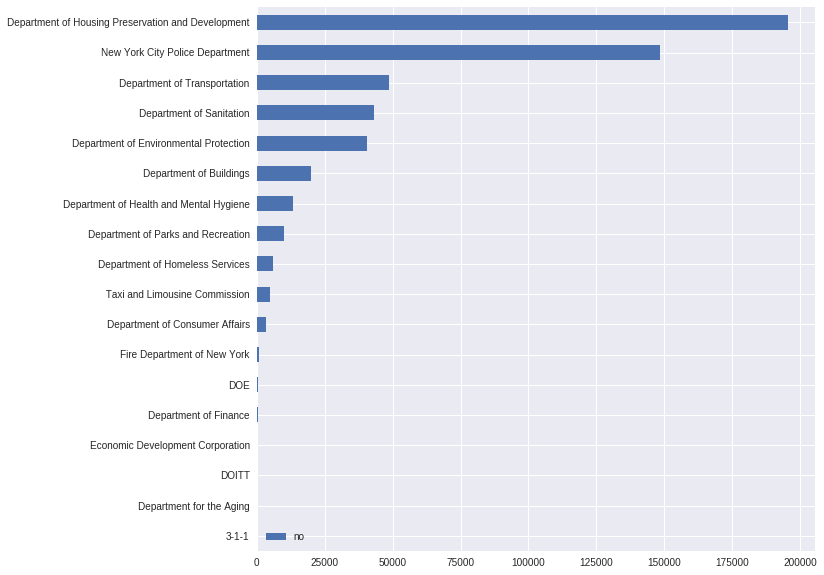

In [21]:
complaints = get_complaint_types('new_york_311', complaint_col='agency').set_index('agency')
complaints.index = [ c if c not in agency_dictionary else agency_dictionary[c]  for c in complaints.index]
complaints.sort_values(by='no', ascending=True).tail(40).plot(kind='barh', figsize=(10,10))

In [22]:
top_complaints = complaints.sort_values(by='no', ascending=True).tail(5)

In [23]:
top_complaints

,no
Department of Environmental Protection,40426
Department of Sanitation,43322
Department of Transportation,48517
New York City Police Department,148568
Department of Housing Preservation and Development,195540


In [46]:
agg=get_aggregated_data(point_table, block_groups, list(top_complaints.index), 'complaint_type')
agg.columns = [ c if c not in agency_dictionary else agency_dictionary[c]  for c in agg.columns]
agg=agg.replace([np.inf, -np.inf], np.nan)
agg_top = agg[top_complaints.index]


        with agg as (
        SELECT block_group_id,agency, count(*) as no
        FROM new_york_311
        where
         block_group_id is not null
        group by block_group_id,agency
        )
        select agg.*, total_pop from agg,
        stuartlynn.ny_block_groups 
        where ny_block_groups.geom_refs = agg.block_group_id
    
https://stuartlynn.carto.com/api/v2/sql?q=%0A++++++++with+agg+as+%28%0A++++++++SELECT+block_group_id%2Cagency%2C+count%28%2A%29+as+no%0A++++++++FROM+new_york_311%0A++++++++where%0A+++++++++block_group_id+is+not+null%0A++++++++group+by+block_group_id%2Cagency%0A++++++++%29%0A++++++++select+agg.%2A%2C+total_pop+from+agg%2C%0A++++++++stuartlynn.ny_block_groups+%0A++++++++where+ny_block_groups.geom_refs+%3D+agg.block_group_id%0A++++&format=csv


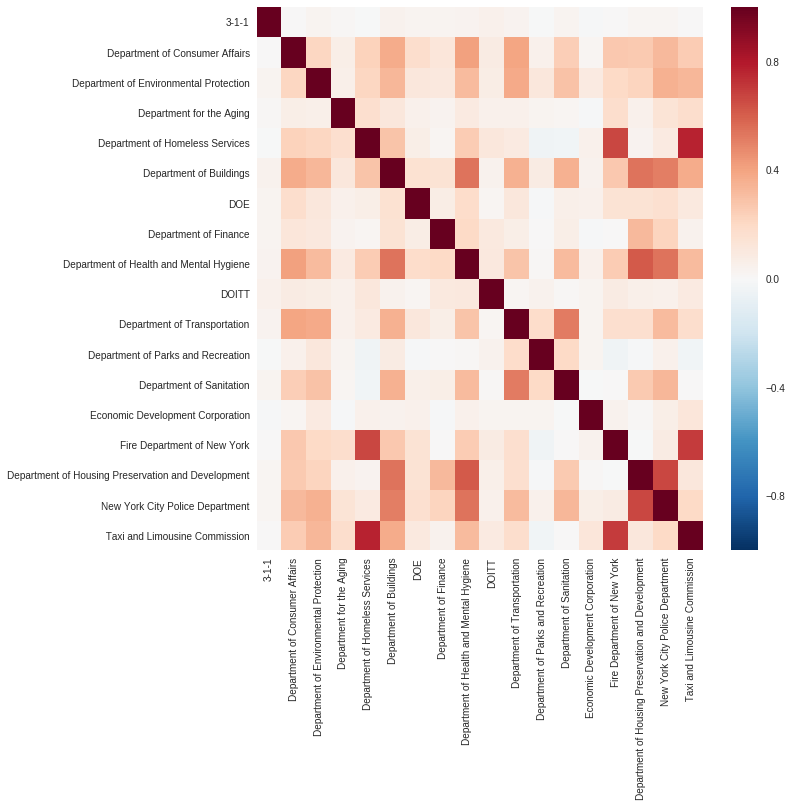

In [131]:
plt.figure(figsize=(10,10))
sbn.heatmap(agg_tract.corr())

In [35]:
from sklearn.cluster import KMeans
from sklearn.cluster import dbscan
from sklearn.metrics import silhouette_samples, silhouette_score

For n_clusters = 2 The average silhouette_score is : 0.47935844417


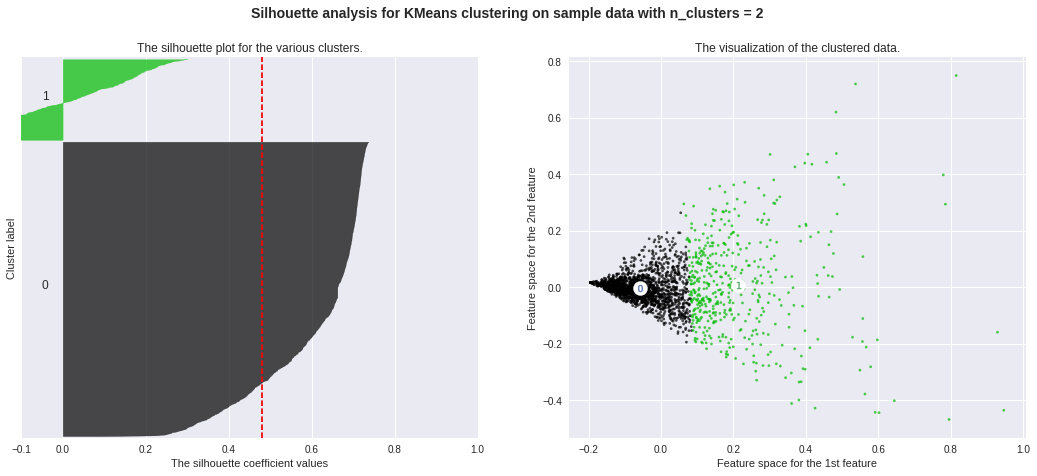

For n_clusters = 3 The average silhouette_score is : 0.455313409861


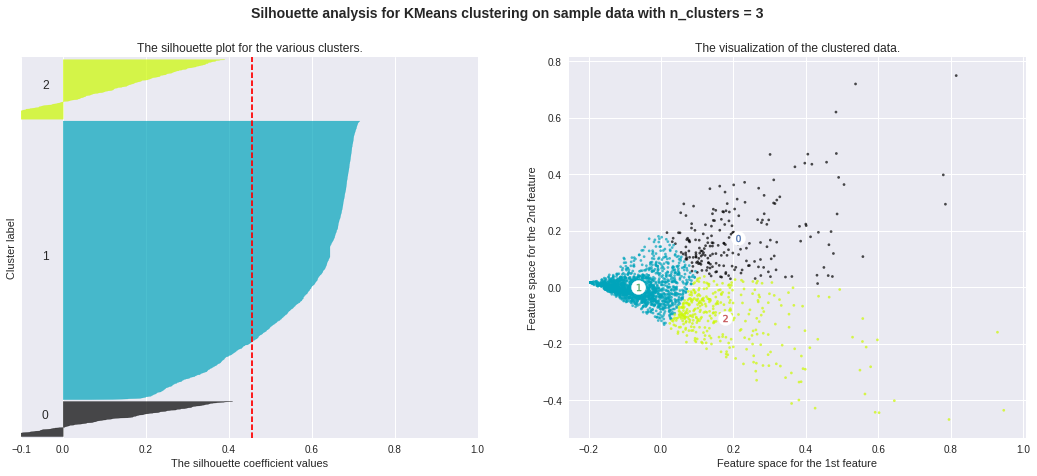

For n_clusters = 4 The average silhouette_score is : 0.319471613586


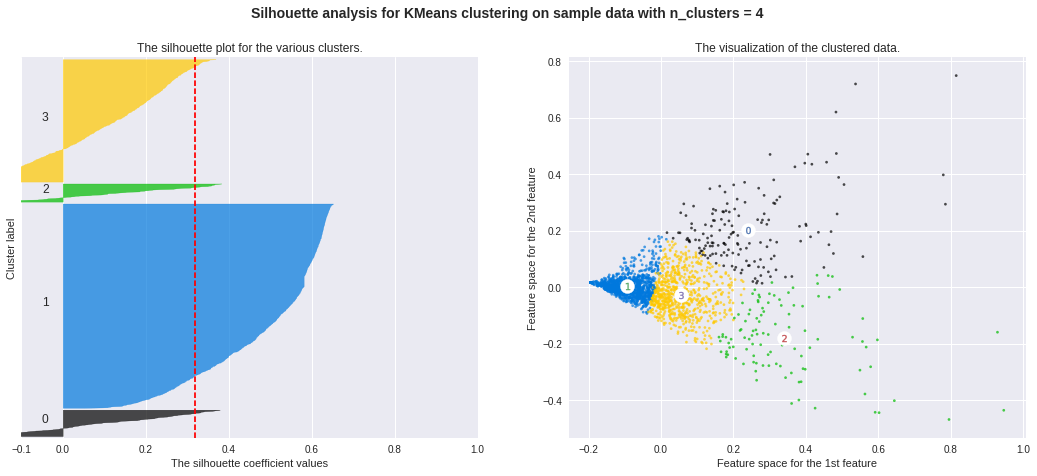

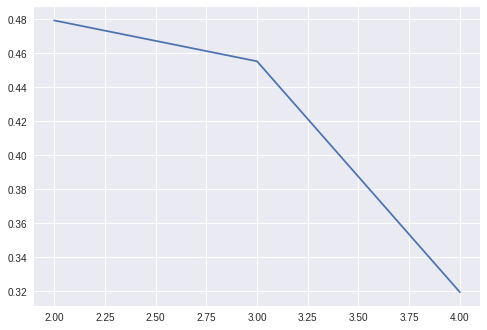

In [134]:
range_n_clusters = [2, 3, 4, 5, 6,10,26,40]
normed = (agg_tract_top - agg_tract_top.min())/(agg_tract_top.max() - agg_tract_top.min())
normed=normed.fillna(0)
data=normed.as_matrix()
# data= agg.as_matrix()
data[data == np.inf] = 0
avg_scores = []

clustered_data = agg_tract_top.copy()
for n_clusters in range(2,5):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data, cluster_labels)
    avg_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    
    clustered_data['labels_{0}'.format(n_clusters)] = cluster_labels
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    pca =  PCA(n_components=2)
    pca_data = pca.fit_transform(data)
    
    ax2.scatter(pca_data[:, 0], pca_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    pca_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(pca_centers[:, 0], pca_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(pca_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
plt.plot(np.arange(2,5), avg_scores) 

For n_clusters = 2 The average silhouette_score is : 0.405940244005


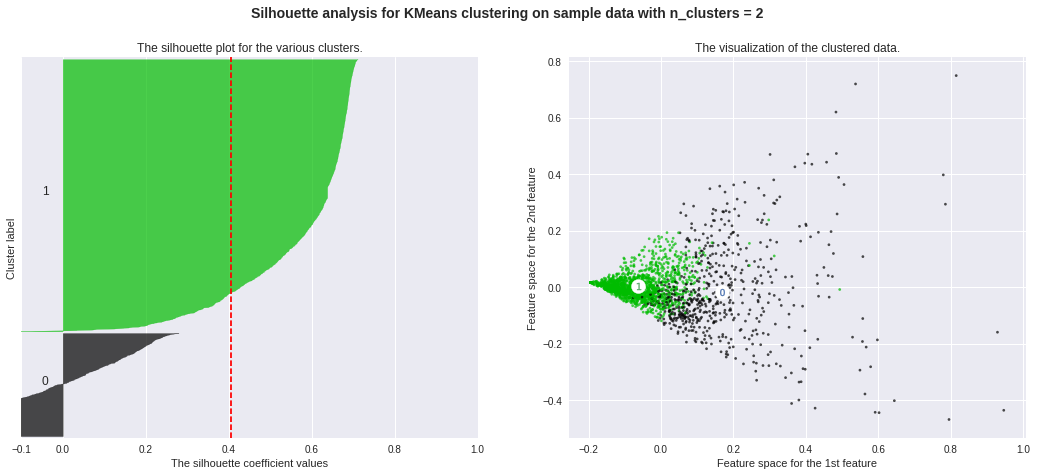

For n_clusters = 3 The average silhouette_score is : 0.407078426863


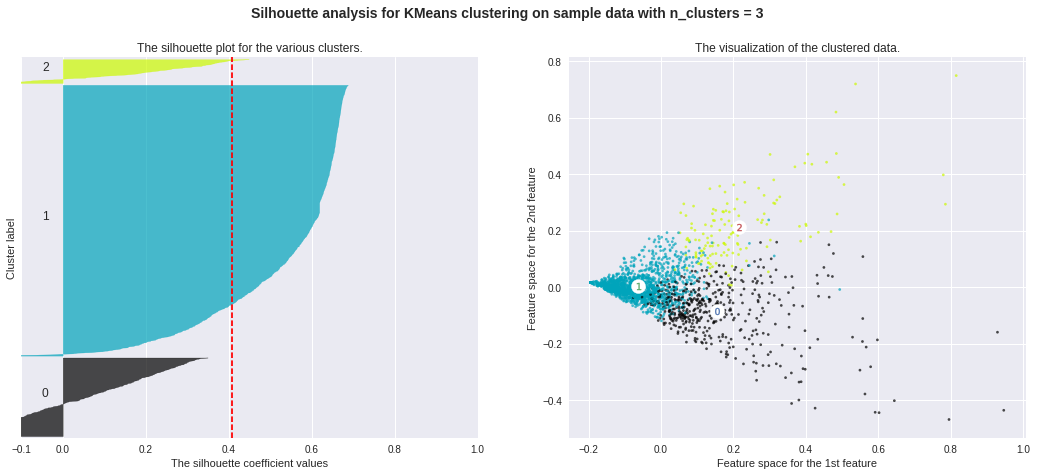

For n_clusters = 4 The average silhouette_score is : 0.352559696941


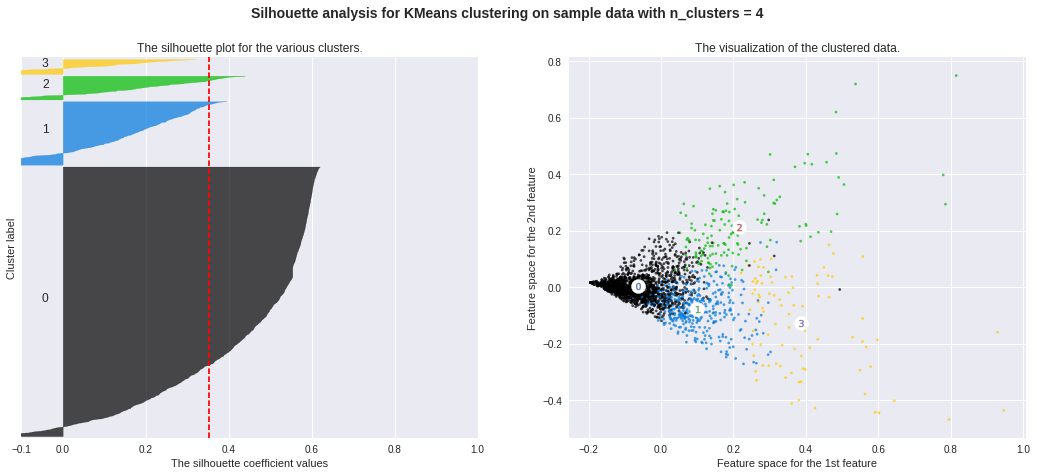

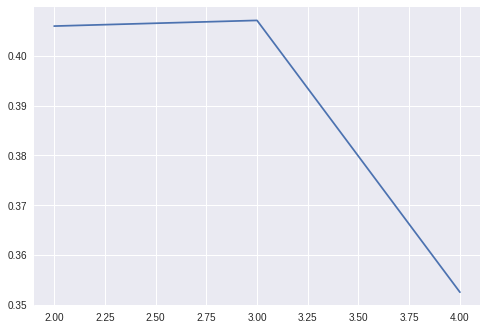

In [121]:
from sklearn.cluster import AgglomerativeClustering


range_n_clusters = [2, 3, 4, 5, 6,10,26,40]
normed = (agg_tract_top - agg_tract_top.min())/(agg_tract_top.max() - agg_tract_top.min())
normed=normed.fillna(0)
data=normed.as_matrix()
# data= agg.as_matrix()
data[data == np.inf] = 0
avg_scores = []

clustered_data = agg_tract_top.copy()
for n_clusters in range(2,5):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data, cluster_labels)
    avg_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    
    clustered_data['labels_{0}'.format(n_clusters)] = cluster_labels
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    pca =  PCA(n_components=2)
    pca_data = pca.fit_transform(data)
    
    ax2.scatter(pca_data[:, 0], pca_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = normed.assign(labels=cluster_labels).groupby('labels').mean()
    pca_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(pca_centers[:, 0], pca_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(pca_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
plt.plot(np.arange(2,5), avg_scores) 

In [135]:
clustered_data.to_csv('nyc_311_clustering_agencies_tracts.csv')


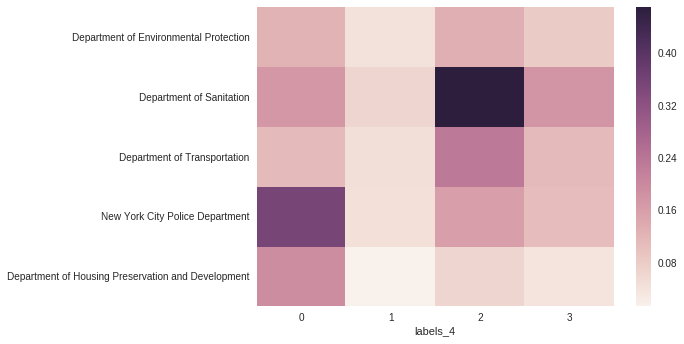

In [136]:
sbn.heatmap(normed.assign(labels_4 = clustered_data['labels_4']).groupby('labels_4').mean().ix[:,0:5].T)

In [38]:
agg_tract_top.groupby('clustermean()*100

Department of Environmental Protection                0.032602
Department of Sanitation                              0.038449
Department of Transportation                          0.042337
New York City Police Department                       0.156791
Department of Housing Preservation and Development    0.244867
dtype: float64

In [ ]:
tsne = TSNE(n_components=2)
transformed= tsne.fit_transform(data)

In [ ]:
plt.figure(figsize=(20,20))
for index,a in enumerate(np.arange(2,22)):
    plt.subplot(4,5,index+1)
    
    cp = sbn.color_palette("Set2", a)
    colors =[cp[a] for a in clustered_data['labels_{0}'.format(a)]]
    plt.scatter(transformed[:,0],transformed[:,1], c= colors, marker='.')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b5ee8bbe0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6b5e3a8240>]], dtype=object)

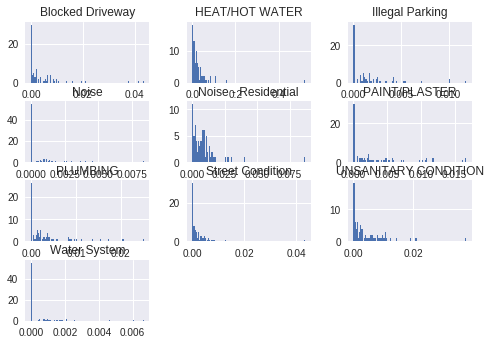

In [122]:
agg.hist(bins=100)

In [80]:
def color_pallet_for_labels(label_count):
    return '\n'.join(['[label_count = {0}] {{polygon-fill: {1} }}'.format(index,h) for index,h in enumerate(sbn.color_palette('bright',20).as_hex())])
    
    

In [81]:
color_pallet_for_labels(20)

'[label_count = 0] {polygon-fill: #003fff }\n[label_count = 1] {polygon-fill: #03ed3a }\n[label_count = 2] {polygon-fill: #e8000b }\n[label_count = 3] {polygon-fill: #8a2be2 }\n[label_count = 4] {polygon-fill: #ffc400 }\n[label_count = 5] {polygon-fill: #00d7ff }\n[label_count = 6] {polygon-fill: #003fff }\n[label_count = 7] {polygon-fill: #03ed3a }\n[label_count = 8] {polygon-fill: #e8000b }\n[label_count = 9] {polygon-fill: #8a2be2 }\n[label_count = 10] {polygon-fill: #ffc400 }\n[label_count = 11] {polygon-fill: #00d7ff }\n[label_count = 12] {polygon-fill: #003fff }\n[label_count = 13] {polygon-fill: #03ed3a }\n[label_count = 14] {polygon-fill: #e8000b }\n[label_count = 15] {polygon-fill: #8a2be2 }\n[label_count = 16] {polygon-fill: #ffc400 }\n[label_count = 17] {polygon-fill: #00d7ff }\n[label_count = 18] {polygon-fill: #003fff }\n[label_count = 19] {polygon-fill: #03ed3a }'

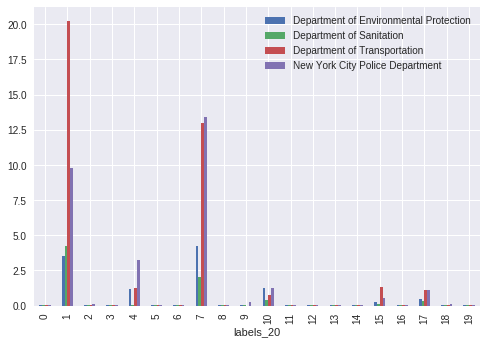

In [92]:
clustered_data.groupby('labels_20').mean().ix[:,0:4].plot(kind='bar')

## GWR

In [170]:
def get_aggregated_data_GWR(point_table, geom_table, categories, category_col, geom_id):
    query='''
        with agg as (
        SELECT {geom_id}, count(*) as no
        FROM  {point_table}
        where {geom_id} is not null
        group by {geom_id}
        )
        select agg.*, total_pop, coalesce(pc_white/total_pop, 0) as pc_white, median_income , ST_X(ST_CENTROID({geom_table}.the_geom)) as lon, 
        ST_Y(ST_CENTROID({geom_table}.the_geom)) as lat, coalesce(no/total_pop,0) as normalized
        FROM 
        {geom_table} , agg
        where {geom_table}.name = agg.{geom_id} and total_pop > 0 and coalesce(no/total_pop,0)<1
    '''.format(point_table=point_table, 
               geom_table=geom_table,
               category_col=category_col,
               geom_id = geom_id
               )
              
    print(query)
    params = {'q': query, 'format':'csv' }
    print('https://stuartlynn.carto.com/api/v2/sql?'+ urlencode(params))

    result =  (pd.read_csv('https://stuartlynn.carto.com/api/v2/sql?'+ urlencode(params)))

#     print(result)
    result.set_index(geom_id)
#     pivot['total_pop'] = result['total_pop']
   
    return result

In [171]:
gwr_data = get_aggregated_data_GWR('new_york_311', 'ny_census_tracts', None, 'agency', 'tract_id')
# gwr_data.columns = [ c if c not in agency_dictionary else agency_dictionary[c]  for c in gwr_data.columns]


        with agg as (
        SELECT tract_id, count(*) as no
        FROM  new_york_311
        where tract_id is not null
        group by tract_id
        )
        select agg.*, total_pop, coalesce(pc_white/total_pop, 0) as pc_white, median_income , ST_X(ST_CENTROID(ny_census_tracts.the_geom)) as lon, 
        ST_Y(ST_CENTROID(ny_census_tracts.the_geom)) as lat, coalesce(no/total_pop,0) as normalized
        FROM 
        ny_census_tracts , agg
        where ny_census_tracts.name = agg.tract_id and total_pop > 0 and coalesce(no/total_pop,0)<1
    
https://stuartlynn.carto.com/api/v2/sql?q=%0A++++++++with+agg+as+%28%0A++++++++SELECT+tract_id%2C+count%28%2A%29+as+no%0A++++++++FROM++new_york_311%0A++++++++where+tract_id+is+not+null%0A++++++++group+by+tract_id%0A++++++++%29%0A++++++++select+agg.%2A%2C+total_pop%2C+coalesce%28pc_white%2Ftotal_pop%2C+0%29+as+pc_white%2C+median_income+%2C+ST_X%28ST_CENTROID%28ny_census_tracts.the_geom%29%29+as+lon%2C+%0A++++++++ST_Y%28ST_CENTROID%28ny_ce

In [172]:
from pysal.contrib.gwr.sel_bw import Sel_BW
from pysal.contrib.gwr import gwr
from pysal.contrib.glm.family import Gaussian

In [195]:
coords  = gwr_data[['lon','lat']].as_matrix()
y = np.array(gwr_data['normalized'].as_matrix())
y = y.reshape(-1,1)
X = np.array(gwr_data[['pc_white','median_income']].fillna(gwr_data[['pc_white','median_income']].mean()).as_matrix())

bw = Sel_BW(coords, y, X, kernel='bisquare', fixed=False)
bw = bw.search(search='golden_section', criterion='AICc')
print(bw)

48.0


In [196]:
model = gwr.GWR(coords, y, X, bw, family=Gaussian(), fixed=False, kernel='bisquare')
results = model.fit()

In [197]:
r2 = results.localR2
intercept = results.params[:,0]
beta_white  = results.params[:,1]
beta_income = results.params[:,2]

with open('correlations','w') as f:
    gwr_data.assign(r2 = r2, intercept = intercept, beta_pc_white=beta_white, beta_income=beta_income).to_csv('correlations.csv')



In [202]:
beta_income

array([ -6.84654425e-08,   8.90767429e-07,  -1.00127445e-06, ...,
        -1.72722114e-07,  -2.22723305e-06,  -3.31710559e-07])

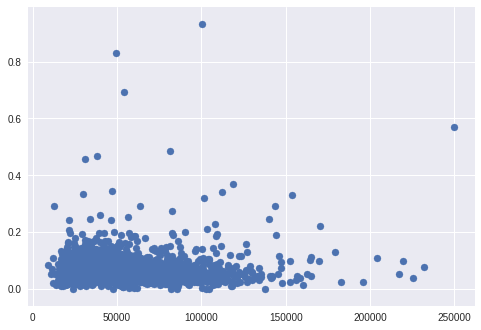

In [177]:
plt.scatter(gwr_data['median_income'], gwr_data['normalized'])